# Building User Interfaces For AI Applications with Gradio in Python

# Creating User Interfaces for AI Applications with Gradio

## Introduction


The usefulness of today's AI models are greatly diminished without accessible user interfaces. Using Gradio, an open-source Python web UI library, you can bridge that gap between LLMs and non-technical end users. It allows you to create rapid prototypes for your AI projects and simplify their deployment to a wider audience. 

This tutorial is aimed at machine learning engineers who typically don't have any web development experience. It covers:
 
- Gradio basics and core concepts
- Interface creation for various AI model types
- Advanced features for UX and interactivity
- Deployment and sharing best practices

Let's get started.

## Getting Started with Gradio

### Installation

We will get started by creating a virtual environment (preferably Conda):

```
$ conda create -n gradio_tutorial python=3.9 -y
$ conda activate gradio_tutorial
```

Then, you can use PIP to install Gradio and its dependencies:

```
$ pip install gradio ipykernel
```

We've also installed the `ipykernel` package so that we can display Gradio interfaces straight within Jupyter notebooks. This process requires you to add the virtual environment you created as a kernel to Jupyter Lab. Here is the command to do it:

```
$ ipython kernel install --user --name==gradio_tutorial
$ jupyter lab  # Start the lab
```

This should allow you to create a notebook with a kernel that has Gradio installed. To verify, import it under its standard alias and print its version:

In [1]:
import gradio as gr

print(gr.__version__)

4.37.1


### Basic concepts and terminology

We will dive into Gradio by learning its key concepts and terminology through a "Hello World" example:

```python
def greet(name):
    return f"Hello, {name}!"


demo = gr.Interface(
    fn=greet,
    inputs=['text'],
    outputs="text",
)

demo.launch()
```

When you run the above code in a cell, the output will be a small interactive interface that returns a custom greeting message:

![](images/hello_world.gif)

Gradio revolves around a few key concepts:
1. `Interface`: the core class for creating UIs.
2. Components: Input and output elements like text boxes, images and audio. There are more than 30 built-in components as of now. 
3. Functions: Python functions that processes the information from the input components and returns the results to display with output components.
4. Launch: The method to start your Gradio app. 

Above, we created a `greet` function that takes and returns a text input. For this reason, the input and output components are specified as `text` inside the `Interface` class. 

In the end, we are calling the `launch` method, which starts a local server. To make the UI available to anyone, you can set the `share` parameter to True. This will start an SSH tunnel and deploys the Gradio app to a publicly shareable webpage:

```python
demo.launch(share=True)
```

```
Running on public URL: https://d638ed5f2ce0044296.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
```

## Gradio Components

You will spend most of your time by tinkering around different components and how to place them on the page while building Gradio apps. So, let's take a closer look at what you have in your disposal.

### Input and output components

Gradio offers a wide array of components for building interactive interfaces. These components are generally divided into two categories: input and output. 

Input components allow users to provide data to the underlying processor (this can be any Python function). Some common inputs are:
- Textbox
- Image
- Audio
- Slider
- Dropdown

Here is a dummy interface that uses some of the components above:

```python
def process_inputs(text, image, audio, number, option):
    # Process inputs and return results
    return f"Processed: {text}, {number}, {option}"


demo = gr.Interface(
    fn=process_inputs,
    inputs=[
        gr.Textbox(label="Enter text"),
        gr.Image(label="Upload image"),
        gr.Audio(label="Upload audio"),  # Uncomment this line to add audio input
        gr.Slider(0, 100, label="Choose a number"),
        gr.Dropdown(["Streamlit", "Taipy", "Gradio"], label="Select a UI library"),
    ],
    outputs="text",
)

demo.launch()
```

In this example, the `process_inputs` function requires five parameters. Therefore, we need to create five input components and pass them to `inputs`. While the number of input components should match the number of required function parameters, this is not a strict rule. To avoid errors and warnings, set default values for parameters that do not require user input from the UI.

![](images/components.gif)

Notice how we are using a `Textbox` class to specify the input component instead of a plain string `text` like the first example. It is always recommended to use dedicated classes for specifying input and output components to make them customizable. For example, all component classes have a useful `label` attribute, while `Slider` and `Dropdown` have arguments to specify range and available options. 

Many input components can be used for displaying output as well. Here are some common scenarios:
- Label: For displaying text or classification results
- Image: For showing processed or generated images
- Audio: For playing processed or generated audio
- Plot: For displaying graphs or charts

Like inputs, the number of output components must match the number of returned values from the processing function. 

### Customizing component appearance

Gradio allows you to customize the appearance of your components to suit your needs. Here is an example that uses customized text boxes:

```python
demo = gr.Interface(
    fn=lambda x: int(x) ** 7,
    inputs=gr.Textbox(
        lines=5,
        placeholder="Enter any number...",
        label="Custom textbox",
        info="This is a customized textbox component to raise any number to the power of 7.",
    ),
    outputs=gr.Textbox(label="And the number is...", show_copy_button=True),
)

demo.launch()
```

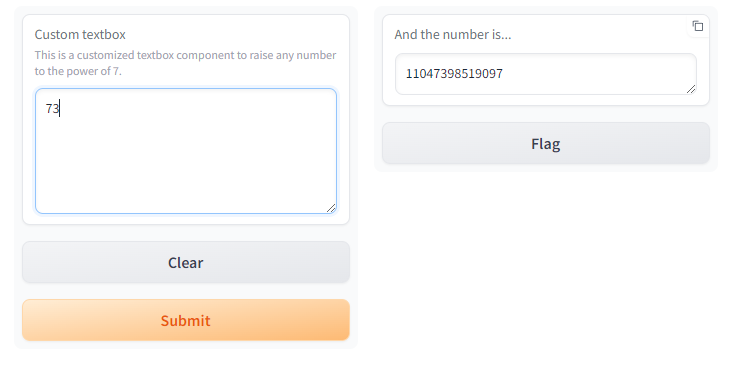

In this example, we've customized the Textbox components by specifying the number of lines, adding a placeholder and info text, and including a copy button for the output.

Experiment with different components and their properties to create interfaces that best suit your AI application's requirements. To find out what kind of properties you can change for your component, you can visit its docs or better yet, use the `?` operand in Jupyter Lab after its class name:

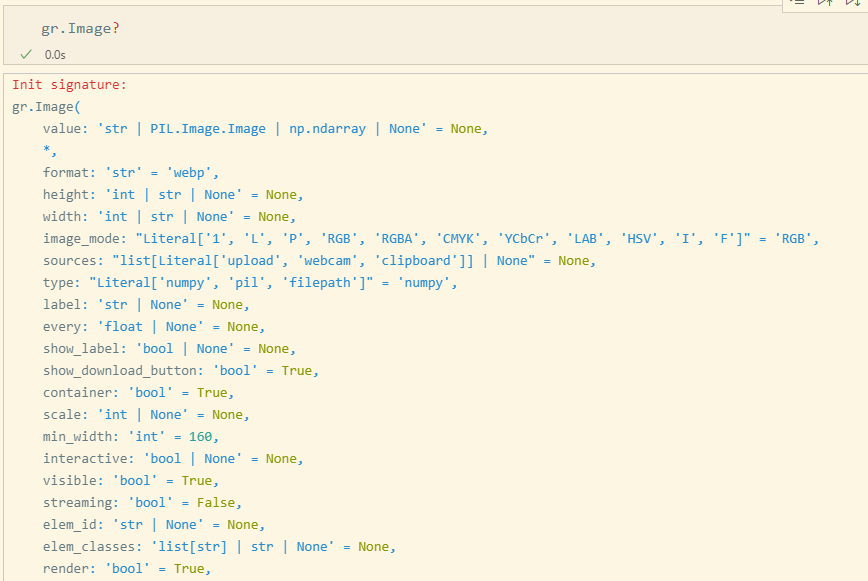

## Building Interfaces For  LLMs

Let's put everything we've learned together by creating two real-world text and image-based interfaces that are powered by LLMs. 

First, we will build a language translator from English to Turkish, Spanish or Chinese:

In [8]:
import openai  # pip install openai


def translate_text(api_key, text, target_language):
    
    openai.api_key = api_key  # Set openai API key
    
    language_map = {
        "Turkish": "Turkish",
        "Spanish": "Spanish",
        "Chinese": "Chinese (Simplified)",
    }
    prompt = f"Translate the following English text to {language_map[target_language]}:\n\nEnglish: {text}\n\n{target_language} translation:"

    try:
        response = openai.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a professional translator."},
                {"role": "user", "content": prompt},
            ],
        )
        translation = response.choices[0].message.content.strip()
        return translation
    except Exception as e:
        return f"Error: {str(e)}"

Initially, we define a `translate_text` function. In its body, we set the OpenAI API key and create a language map. Then, we construct the prompt for translation. Then, inside a `try-except` block, we send a request to the `ChatCompletion` endpoint with a system prompt. In the end, we return the first choice. 

Now, we can build the interface:

```python
iface = gr.Interface(
    fn=translate_text,
    inputs=[
        gr.Textbox(
            placeholder="Enter your OpenAI API key",
            type="password",
            label="OpenAI API Key",
        ),
        gr.Textbox(
            lines=4,
            placeholder="Enter English text to translate...",
            label="English Text",
        ),
        gr.Dropdown(choices=["Turkish", "Spanish", "Chinese"], label="Target Language"),
    ],
    outputs=gr.Textbox(label="Translation", show_copy_button=True),
    title="English to Turkish/Spanish/Chinese Translator",
    description="Translate English text to Turkish, Spanish, or Chinese using OpenAI's GPT-4 model. Enter your OpenAI API key, the text you want to translate, and select the target language.",
)

iface.launch(share=True)
```

The code is simple like those of earlier interfaces but we are introducing a couple of new properties:
- `type` argument of text boxes change the plain-text input field to password input, hiding the text.
- `title` and `description` arguments of `Interface` class adds an H1 title and a subtitle to the top center of the page.

Here is the result:

![](images/translator.gif)

You might wonder why we are asking user's API key as part of the app rather than provide it ourselves. The reason has got to do with how Gradio deploys UIs.

If we provided our own API key as an environment variable (which is a standard practice), the publicly shareable app version wouldn't work as it wouldn't have access to our environment variables. In the deployment section, we will see how to fix this by deploying our apps to HuggingFace spaces.

Let's build another UI for generating images:

In [29]:
def generate_surrealist_art(api_key, prompt):
    surrealist_prompt = f"Create a surrealist artwork based on the following concept: {prompt}. The artwork should be dreamlike, with unexpected juxtapositions and a sense of the uncanny."

    client = OpenAI(api_key=api_key)

    response = client.images.generate(
        model="dall-e-3",
        prompt=surrealist_prompt,
        size="1024x1024",
    )

    image_url = response.data[0].url

    return image_url

We create a function named `generate_surrealist_art` that sends a request to `dall-e-3` and returns the generated image URL using a surrealist prompt. Then, we will feed this function into an `Interface` class again:

```python
iface = gr.Interface(
    fn=generate_surrealist_art,
    inputs=[
        gr.Textbox(
            placeholder="Enter your OpenAI API key",
            type="password",
            label="OpenAI API Key",
        ),
        gr.Textbox(
            lines=2,
            placeholder="Describe your surrealist concept...",
            label="Concept Description",
        ),
    ],
    outputs=gr.Image(value="str"),
    title="Surrealist Artwork Generator",
    description="Generate surrealist artwork based on your prompts using DALL-E. Enter your OpenAI API key and describe your concept.",
)

iface.launch(share=True)
```

We specify two inputs for the API key and the concept we want to capture in a surrealist image. Then, we create one output component for the generated image with the `Image` class. If you set its `value` argument to `str`, the component can download and display images from URLs, which is just what we need. 

And here is the result:

![](images/image_generator_2.gif)

## Building Interfaces For Classic ML Models

Now, let's build an interface for a classic tabular regression model. We will use the Diamonds dataset, which is available in Seaborn.

Start by creating a new working directory and a new script named `app.py` inside. Then, paste the code from [this GitHub gist](https://gist.github.com/BexTuychiev/e3ecdbf0e6feabc84f4ebd32ba17dd38) that loads the data, processes it using a Scikit-learn `Pipeline` and trains a `RandomForestRegression` model. 

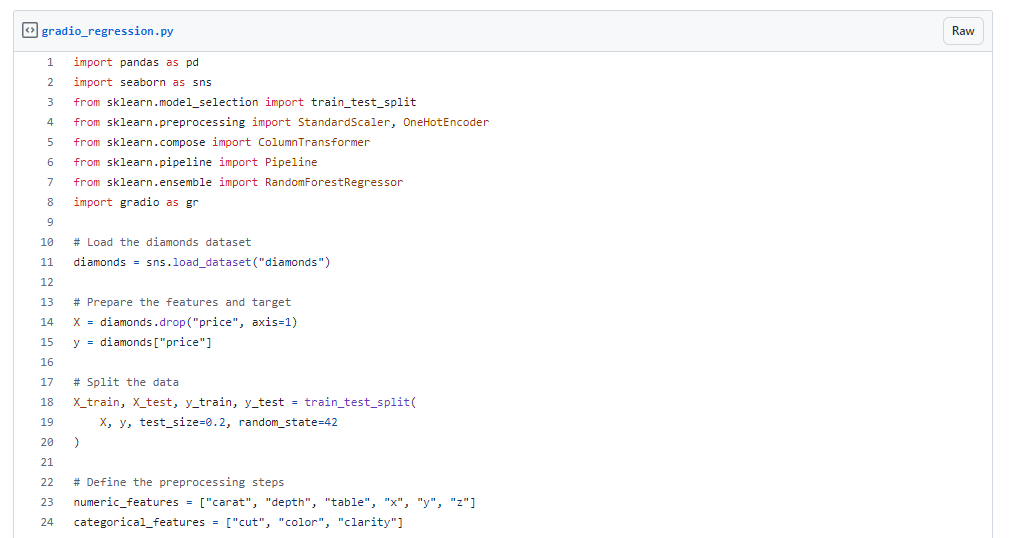

The next step is to create a processing function that accepts the same number of inputs as there are features in the Diamonds dataset:

In [31]:
# Create the Gradio interface
def predict_price(carat, cut, color, clarity, depth, table, x, y, z):
    
    input_data = pd.DataFrame(
        {
            "carat": [carat],
            "cut": [cut],
            "color": [color],
            "clarity": [clarity],
            "depth": [depth],
            "table": [table],
            "x": [x],
            "y": [y],
            "z": [z],
        }
    )
    
    prediction = model.predict(input_data)[0]
    return f"Predicted Price: ${prediction:.2f}"

The function converts those inputs into a DataFrame and passes it to the `.predict()` method of the trained model pipeline. In the end, it returns a string with the predicted price. 

Now, the `Interface` class must match this function's signature: nine input components for processing the features and one output for displaying the predicted price:

```python
iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Slider(
            minimum=diamonds["carat"].min(),
            maximum=diamonds["carat"].max(),
            label="Carat",
        ),
        gr.Dropdown(["Fair", "Good", "Very Good", "Premium", "Ideal"], label="Cut"),
        gr.Dropdown(["D", "E", "F", "G", "H", "I", "J"], label="Color"),
        gr.Dropdown(
            ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"], label="Clarity"
        ),
        gr.Slider(
            minimum=diamonds["depth"].min(),
            maximum=diamonds["depth"].max(),
            label="Depth",
        ),
        gr.Slider(
            minimum=diamonds["table"].min(),
            maximum=diamonds["table"].max(),
            label="Table",
        ),
        gr.Slider(minimum=diamonds["x"].min(), maximum=diamonds["x"].max(), label="X"),
        gr.Slider(minimum=diamonds["y"].min(), maximum=diamonds["y"].max(), label="Y"),
        gr.Slider(minimum=diamonds["z"].min(), maximum=diamonds["z"].max(), label="Z"),
    ],
    outputs="text",
    title="Diamond Price Predictor",
    description="Enter the characteristics of a diamond to predict its price.",
)

iface.launch(share=True)
```

Inside the class, we create three dropdowns for the categorical features. The options are filled in with the unique categories in each feature. We also create six slider components to accept numeric features. The ranges of sliders are determined by the minimum and maximum values of each feature. 

All we have to do now is to execute the script to run and deploy the app:

```
$ python app.py
```

Here is the result:

![](images/prices_regression.gif)

For best practices and optimization tips, skip to the Best Practices section below.

## Deploying Gradio Apps

We've already seen how easy it is to deploy Gradio apps by enabling a single argument. Of course, the disadvantage of this method is that the demos expire within 72 hours. So, the recommended method of deploying Gradio is through HuggingFace Spaces. HuggingFace acquired Gradio in 2021, making the integration between two platforms seamless. 

So, for this tutorial's or any future apps you create with Gradio, sign up for a free account at [huggingface.co](https://huggingface.co) and navigate to [Settings > Tokens](https://huggingface.co/settings/tokens) to generate an access token:

![](images/generate_token.gif)

The token is displayed only once, so be sure to store it somewhere safe.

With this token, you can deploy as many Gradio apps as you want with permanent hosting on Spaces. As an example, we will deploy the Diamond Prices Prediction model from the previous section and you will find it surprisingly easy. 

All you have to do is to navigate to the directory with the UI script and call `gradio deploy` on the terminal:

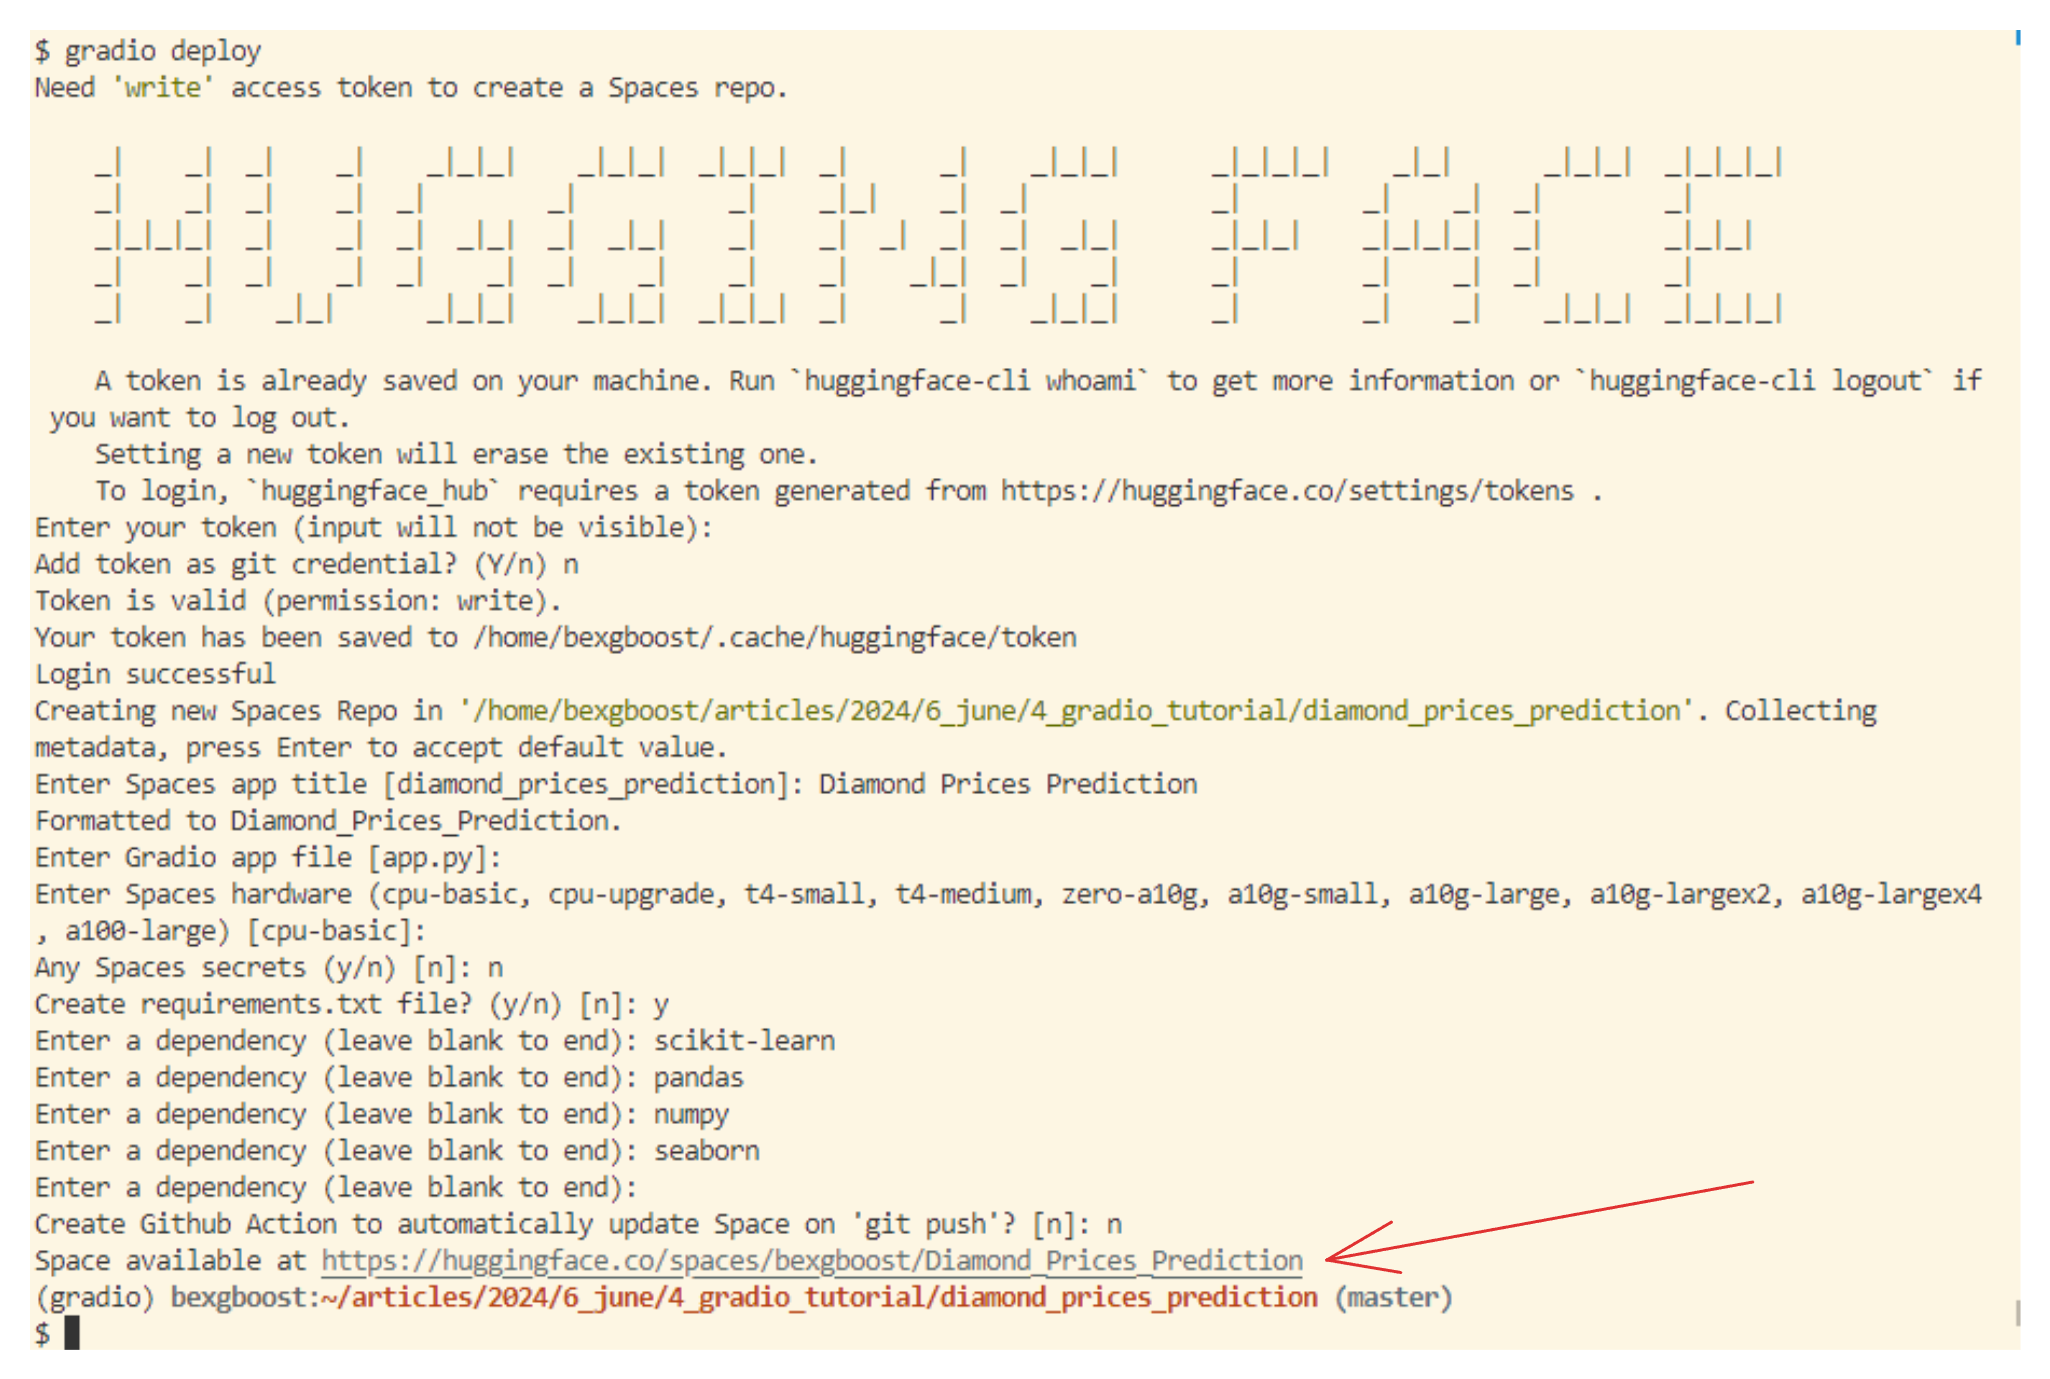

The terminal walks you through converting your script to a functioning HuggingFace Space. It asks details such as:
- The access token you generated
- Space title: this will be part of the Space URL after deployment
- The name of the script containing Gradio UI code (`app.py` default)
- Space's hardware; leave empty to use only CPUs (free)
- Any environment variables the script uses (this is where you store API keys and user secrets securely)
- Dependencies - enter one-by-one by pressing ENTER

And the terminal presents you with a deployed Space link. Here is what it looks like:

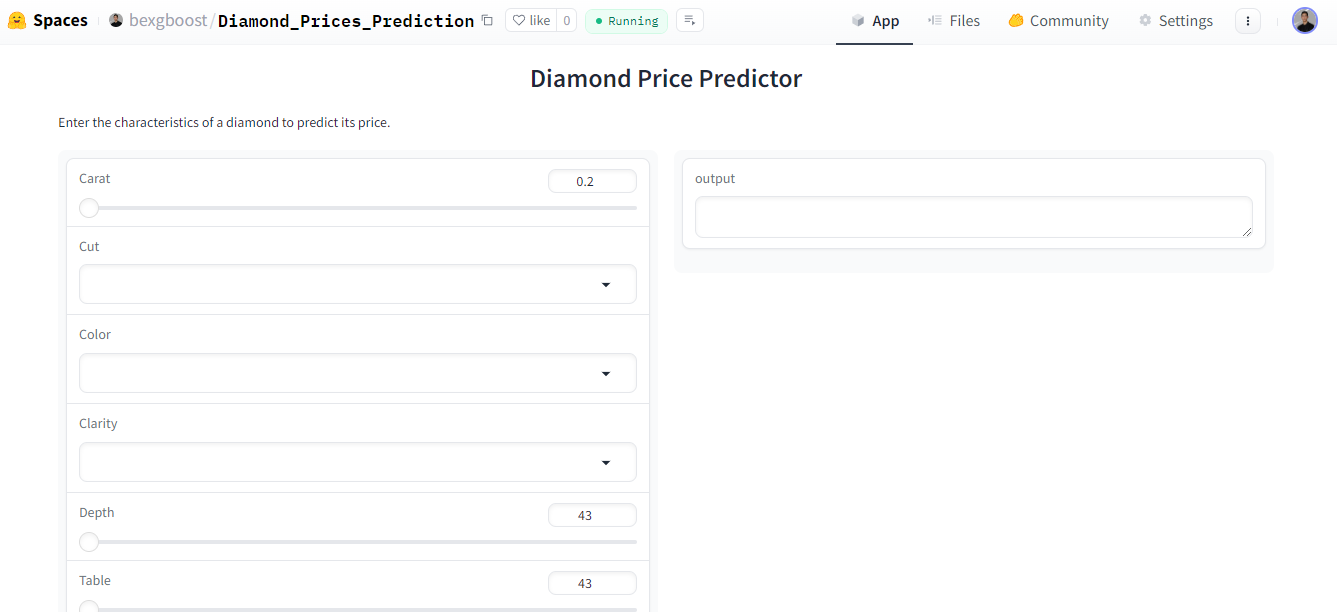

Another great thing with this method of deployment is that Gradio automatically converts the demo to a working REST API. The instructions to access and query it is always located at the bottom:

![](images/rest_api.gif)

So, in one go, you have both permanent UI hosting for your application for non-technical users and a REST API for your colleagues and developer friends. 

For more deployment and sharing options such as embedding demos into webpages, adding Google authentication to apps, etc. visit the ["Sharing Your App"](https://www.gradio.app/main/guides/sharing-your-app) section of Gradio's documentation.

## Best Practices and Tips

When developing user interfaces with Gradio, following best practices can significantly improve the user experience and maintainability of your application. Here are some key recommendations:

1. Use scripts for organization and maintainability

Organize Gradio applications in Python scripts for better version control, collaboration, and deployment.

2. Optimize space allocation for components

Use appropriate sizing and layout tools (e.g., gr.Column(), gr.Row()) to ensure a balanced, responsive interface.

3. Provide comprehensive information

Utilize 'info' and 'label' attributes to give clear instructions and context for each component.

4. Handle large feature sets efficiently

For models with many features, use file inputs (CSV, JSON) to enable batch predictions and simplify the interface.

5. Manage environment variables properly

Use python-dotenv for local development and set variables in Hugging Face Spaces for deployment.

6. Implement error handling and validation

Validate inputs, provide clear error messages, and use try-except blocks for graceful error handling.

7. Optimize performance

Implement caching, lazy loading for large models, and use gr.LoadingStatus() for long-running tasks.

8. Design for accessibility

Ensure high contrast, provide alt text for images, and enable keyboard navigation for all interactive elements.

9. Implement progressive disclosure

Use accordions or tabs to organize complex interfaces, revealing advanced options as needed.

10. Regularly update and maintain

Keep dependencies updated, monitor for bugs, and continuously improve based on user feedback.

11. Leverage HuggingFace resources

Utilize HuggingFace tools and resources for seamless integration with Gradio, including model repositories and datasets.

12. Host large models on HuggingFace Hub

For large tabular models, upload to HuggingFace Hub and load directly in your Gradio script to improve performance and reduce local storage requirements.

13. Utilize HuggingFace datasets

For large datasets, upload to HuggingFace Hub and access them directly in your Gradio application to streamline data management and improve loading times.


## Conclusion and Further Resources

In this article, we have learned the basics of building user interfaces for AI applications using Gradio. We have just dipped below the surface as Gradio offers many more features for building complex interfaces. For example, [interface state](https://www.gradio.app/guides/interface-state) allows your app to remember outputs from one function call to another. [Reactive interfaces](https://www.gradio.app/guides/reactive-interfaces) dynamically change the UI as soon as the user input changes. With [Blocks](https://www.gradio.app/guides/blocks-and-event-listeners), you can build apps with custom layouts and design. 

Similarly, check out these related resources for more content:
- [10 Python Packages to Add to Your Data Science Stack](https://www.datacamp.com/blog/10-python-packages-to-add-to-your-data-science-stack-in-2022)
- [7 Essential Generative AI Tools For Building Stand-out AI Applications](https://www.datacamp.com/blog/10-python-packages-to-add-to-your-data-science-stack-in-2022)
- [5 Projects You Can Build With Gen AI Models](https://www.datacamp.com/blog/5-projects-you-can-build-with-generative-ai-models)
- [CI/CD For Machine Learning Course](https://www.datacamp.com/tutorial/ci-cd-for-machine-learning)